In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

import pmdarima
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")
# from datetime import datetime as dt

# declare beginning and end of series
start_date = datetime.datetime(year=2015, month=3, day=19)
end_date = datetime.datetime(year=2020, month=5, day=26)

# Load in Data
## Unemployment Data

In [2]:
# load unemployment data
claims = pd.read_csv(r'C:\Users\javie\OneDrive\Documents\Academics\SMU\MSDS 6120 - Capstone\Code\claims.csv', header = [0], sep = ',', parse_dates = ['Date'])
claims.set_index('Date',inplace=True)
claims.tail()

,new_claims
Date,
2020-05-22,7489
2020-05-23,3600
2020-05-24,7052
2020-05-25,5034
2020-05-26,8264


## COVID-19 Data

In [3]:
# load data
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
covid = pd.read_csv(url, header = [0], sep = ',', parse_dates = ['date'])

# separate only PA data
covid = covid[covid['state']=='Pennsylvania']

# create master df
covid = covid.pivot(index='date', columns='county', values=['cases', 'deaths'])

# fill nulls w/ 0
covid = covid.fillna(0)

# create subsets df
covid_cases = covid['cases']
covid_deaths = covid['deaths']

# join levels in columns from 2 to 1
covid.columns = ['_'.join(col) for col in covid.columns]

# total cases and deaths
covid['total_cases_deaths'] = covid.sum(axis=1)
# new cases and deaths
covid['new_cases_deaths'] = covid.total_cases_deaths.diff()

# merge total and new cases into main df
covid['total_cases'] = covid_cases.sum(axis=1)
covid['new_cases'] = covid.total_cases.diff()

# merge total and new deaths into main df
covid['total_deaths'] = covid_deaths.sum(axis=1)
covid['new_deaths'] = covid.total_deaths.diff()

# fill nulls in first row w/ 0
covid = covid.fillna(0)

covid = covid[['new_deaths','new_cases']]
covid.tail()

,new_deaths,new_cases
date,,
2020-06-21,5.0,346.0
2020-06-22,3.0,642.0
2020-06-23,36.0,617.0
2020-06-24,57.0,492.0
2020-06-25,34.0,455.0


## Peak Load Power Consumption

In [4]:
load = pd.read_csv('Load.csv', header = [0], sep = ',', parse_dates = ['Date'])
load.set_index('Date',inplace=True)
load = load.dropna()
# load.head()
load.tail()
# load.info()

,Load,Avg.Temp,Max,Avg,Min
Date,,,,,
2020-05-22,4173,62.9,66,62.9,52
2020-05-23,3861,66.2,73,66.2,59
2020-05-24,3604,61.9,71,61.9,55
2020-05-25,3708,63.9,77,63.9,56
2020-05-26,4857,70.2,84,70.2,58


In [5]:
load.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1896 entries, 2015-03-19 to 2020-05-26
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Load      1896 non-null   int64  
 1   Avg.Temp  1896 non-null   float64
 2   Max       1896 non-null   int64  
 3   Avg       1896 non-null   float64
 4   Min       1896 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 88.9 KB


# Blend Data

In [6]:
data = pd.DataFrame()
data = load.join(covid, how='outer')
data = data.join(claims, how='outer')
# data = data.join(holidays, how='outer')

data = data[start_date:end_date]
data = data.fillna(0)

# drop avg
data = data.drop(columns=['Avg.Temp'])

data = data.asfreq('D')

data.tail()

,Load,Max,Avg,Min,new_deaths,new_cases,new_claims
2020-05-22,4173.0,66.0,62.9,52.0,145.0,1053.0,7489.0
2020-05-23,3861.0,73.0,66.2,59.0,89.0,797.0,3600.0
2020-05-24,3604.0,71.0,61.9,55.0,24.0,554.0,7052.0
2020-05-25,3708.0,77.0,63.9,56.0,14.0,700.0,5034.0
2020-05-26,4857.0,84.0,70.2,58.0,16.0,517.0,8264.0


# EDA

## COVID-19

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(covid.new_cases, label = "New Cases",  color = 'black', linestyle='solid')
plt.plot(covid.new_deaths, label = "New Deaths",  color = 'black', linestyle='dashed')
plt.title('New COVID-19 Cases & Deaths in Pennsylvania')
plt.ylabel('New Instances')
plt.xlabel('Date')
plt.grid(False)
plt.legend()
# fig.autofmt_xdate()
# plt.hlines(y=0, xmin=np.min(df.date), xmax=np.max(df.date), linewidth=.5)
ax = plt.gca()

date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)
plt.axvline(pd.to_datetime('2020-04-01'), color = 'black', linestyle = ':')
plt.axvline(pd.to_datetime('2020-06-04'), color = 'black', linestyle = ':')

plt.xticks(rotation=90)
plt.savefig("new_covid.png")
plt.show()

## Unemployment

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(data.index, data.new_claims, label = "New Claims",  color = 'black', linestyle='solid')
plt.title('New Unemployment Claims in Pennsylvania')
plt.ylabel('New Claims')
plt.xlabel('Date')
plt.grid(False)
plt.legend()
ax = plt.gca()
plt.axvline(pd.to_datetime('2020-04-01'), color = 'black', linestyle = ':')
plt.axvline(pd.to_datetime('2020-06-04'), color = 'black', linestyle = ':')

# plt.xticks(rotation=90)
plt.savefig("claims.png")
plt.show()


In [ ]:
claims2020 = claims[datetime.datetime(year=2020, month=1, day=1) : datetime.datetime(year=2020, month=5, day=26)]

plt.figure(figsize=(10,6))
plt.plot(claims2020.index, claims2020.new_claims, label = "New Claims",  color = 'black', linestyle='solid')
plt.title('New Unemployment Claims in Pennsylvania During 2020')
plt.ylabel('New Claims')
plt.xlabel('Date')
plt.grid(False)
plt.legend()
ax = plt.gca()
plt.axvline(pd.to_datetime('2020-04-01'), color = 'black', linestyle = ':')
plt.axvline(pd.to_datetime('2020-06-04'), color = 'black', linestyle = ':')

# plt.xticks(rotation=90)
plt.savefig("2020_claims.png")
plt.show()

## Peak Load Power Consumption

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(load.index, load.Load, label = "Power Consumption (mWh)",  color = 'black', linestyle='solid')
plt.title('Transmission Peak Power Consumption in Pennsylvania (2015 - 2020)')
plt.ylabel('Megawatt Hours (mWh)')
plt.xlabel('Date')
plt.grid(False)
plt.legend()
ax = plt.gca()
plt.axvline(pd.to_datetime('2020-04-01'), color = 'black', linestyle = ':')
plt.axvline(pd.to_datetime('2020-06-04'), color = 'black', linestyle = ':')

# plt.xticks(rotation=90)
plt.savefig("peak_load.png")
plt.show()

In [ ]:
load2020 = load[datetime.datetime(year=2020, month=1, day=1) : datetime.datetime(year=2020, month=5, day=26)]

plt.figure(figsize=(15,6))
plt.plot(load2020.index, load2020.Load, label = "Power Consumption (mWh)",  color = 'black', linestyle='solid')
plt.title('Transmission Peak Power Consumption in Pennsylvania (2020)')
plt.ylabel('Megawatt Hours (mWh)')
plt.xlabel('Date')
plt.grid(False)
plt.legend()
ax = plt.gca()
plt.axvline(pd.to_datetime('2020-04-01'), color = 'black', linestyle = ':')
plt.axvline(pd.to_datetime('2020-06-04'), color = 'black', linestyle = ':')

# plt.xticks(rotation=90)
plt.savefig("2020_load.png")
plt.show()

In [ ]:
temp = data[datetime.datetime(year=2019, month=1, day=1) : datetime.datetime(year=2019, month=12, day=31)]

plt.figure(figsize=(15,6))
plt.plot(temp.index, temp.Load, label = "Power Consumption (mWh)",  color = 'black', linestyle='solid')
plt.title('Transmission Peak Power Consumption in Pennsylvania (2019)')
plt.ylabel('Megawatt Hours (mWh)')
plt.xlabel('Date')
plt.grid(False)
plt.legend()
ax = plt.gca()

# plt.xticks(rotation=90)
plt.savefig("2019_load.png")
plt.show()

In [7]:
#data.to_csv(r'data.csv', index = True)
data = data.drop(columns=['new_deaths'])

In [8]:
train_start,train_end = '2015-03-19','2020-04-28'
test_start,test_end = '2020-04-29','2020-05-12'
preds_start,preds_end = '2020-05-13','2020-05-26'

train = data['Load'][train_start:train_end].dropna()
test = data['Load'][test_start:test_end].dropna()
preds = data['Load'][preds_start:preds_end].dropna()

exog_train = data.drop(['Load'],axis = 1)[train_start:train_end].dropna()
exog_test = data.drop(['Load'],axis = 1)[test_start:test_end].dropna()
exog_pred = data.drop(['Load'],axis = 1)[preds_start:preds_end].dropna()

In [9]:
exog_train = np.asarray(exog_train)
exog_test = np.asarray(exog_test)
exog_pred = np.asarray(exog_pred)

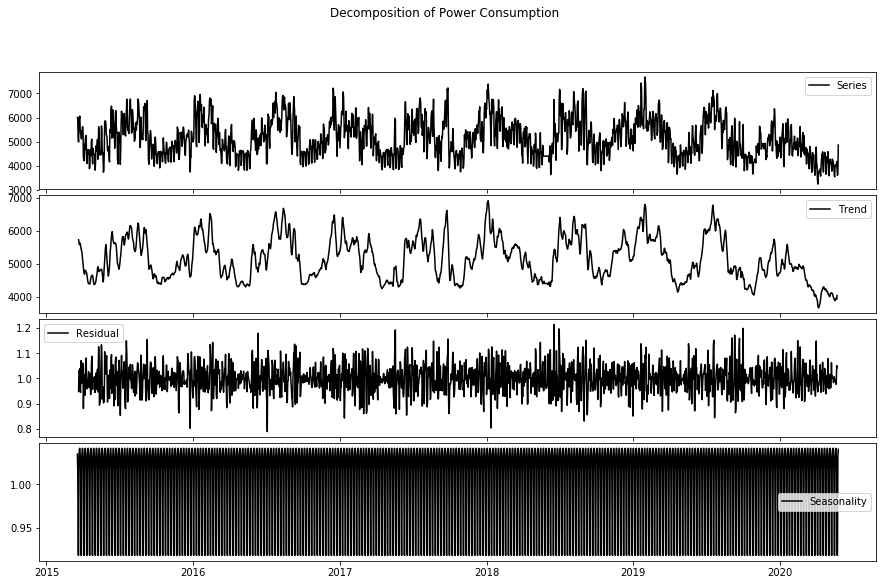

In [10]:
decomposition=seasonal_decompose(data['Load'], model='multiplicative')
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid

fig, axs = plt.subplots(4, figsize=(15,9), sharex=True, sharey=False, gridspec_kw={'hspace': .05})
fig.suptitle('Decomposition of Power Consumption')

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

axs[0].plot(data['Load'],color='black', label='Series')
axs[0].legend(loc='best')

axs[1].plot(trend,color='black', label='Trend')
axs[1].legend(loc='best')

axs[2].plot(residual,color='black', label='Residual')
axs[2].legend(loc='best')

axs[3].plot(seasonal,color='black', label='Seasonality')
axs[3].legend(loc='best')

In [ ]:
#We can see from these results that we will confidently reject the null hypotheis of the dickey fuller test, we can assume this data is stationary.

result = adfuller(data['Load'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

In [ ]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(data['Load'])

In [11]:
#Pyramid Search for Arima Paramaters
Arima_model=auto_arima(train, start_p=1, start_q=1, max_p=5, max_q=5, start_P=0, start_Q=0, max_P=0, max_Q=0, seasonal=False, trace=True, d=1, D=0, error_action='warn', suppress_warnings=True, random_state = 20, n_fits=5)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=28009.865, BIC=28031.994, Time=0.653 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=28225.850, BIC=28236.914, Time=0.031 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=28221.266, BIC=28237.863, Time=0.080 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=28212.660, BIC=28229.256, Time=0.130 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=28223.857, BIC=28229.389, Time=0.016 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=27827.100, BIC=27854.761, Time=0.998 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=28042.755, BIC=28064.883, Time=0.117 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=27828.466, BIC=27861.658, Time=1.429 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=27826.765, BIC=27859.957, Time=1.685 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=27838.129, BIC=27865.789, Time=0.960 seconds
Fit ARIMA(3,1,2)

In [12]:
#Pyramid Search for SARIMA Paramaters
Sarima_model=auto_arima(train, start_p=1, start_q=1, max_p=5, max_q=5, start_P=1, start_Q=1, max_P=5, max_Q=5, m=7, seasonal=True, trace=True, d=1, D=1, error_action='warn', suppress_warnings=True, random_state = 20, n_fits=5)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(1,1,1,7) [intercept=True]; AIC=27095.756, BIC=27128.926, Time=3.202 seconds
Fit ARIMA(0,1,0)x(0,1,0,7) [intercept=True]; AIC=28398.391, BIC=28409.448, Time=0.053 seconds
Fit ARIMA(1,1,0)x(1,1,0,7) [intercept=True]; AIC=27911.235, BIC=27933.348, Time=1.262 seconds
Fit ARIMA(0,1,1)x(0,1,1,7) [intercept=True]; AIC=27241.231, BIC=27263.344, Time=1.481 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,1,0,7) [intercept=False]; AIC=28396.409, BIC=28401.937, Time=0.027 seconds
Fit ARIMA(1,1,1)x(0,1,1,7) [intercept=True]; AIC=27129.273, BIC=27156.915, Time=5.395 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,1)x(1,1,0,7) [intercept=True]; AIC=27671.190, BIC=27698.832, T

In [13]:
print(Arima_model)
print('AIC: ', Arima_model.aic())
print('BIC: ', Arima_model.bic())

ARIMA(order=(5, 1, 3), suppress_warnings=True)
AIC:  27466.984309787178
BIC:  27522.305191222596


In [14]:
print(Sarima_model)
print('AIC: ', Sarima_model.aic())
print('BIC: ', Sarima_model.bic())

ARIMA(order=(2, 1, 1), seasonal_order=(1, 1, 1, 7), suppress_warnings=True)
AIC:  27037.793278532034
BIC:  27076.491600898986


In [15]:
# Fit the models
ARIMA = sm.tsa.statespace.SARIMAX(train, order=(5,1,3)).fit()
SARIMA = sm.tsa.statespace.SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,1,7)).fit()
SARIMAX = sm.tsa.statespace.SARIMAX(train,order=(2,1,1), seasonal_order=(1,1,1,7), exog = exog_train, freq='D').fit()

In [ ]:
print(ARIMA.summary())

In [ ]:
print(SARIMA.summary())

In [ ]:
print(SARIMAX.summary())

In [ ]:
# ARIMA_res = ARIMA.resid
# fig,ax = plt.subplots(2,1,figsize=(15,8))
# fig = sm.graphics.tsa.plot_acf(ARIMA_res, lags=50, ax=ax[0])
# fig = sm.graphics.tsa.plot_pacf(ARIMA_res, lags=50, ax=ax[1])
# plt.show()

In [ ]:
# SARIMA_Res = SARIMA.resid
# fig,ax = plt.subplots(2,1,figsize=(15,8))
# fig = sm.graphics.tsa.plot_acf(SARIMA_Res, lags=50, ax=ax[0])
# fig = sm.graphics.tsa.plot_pacf(SARIMA_Res, lags=50, ax=ax[1])
# plt.show()

In [ ]:
# SARIMAX_Res = SARIMAX.resid
# fig,ax = plt.subplots(2,1,figsize=(15,8))
# fig = sm.graphics.tsa.plot_acf(SARIMAX_Res, lags=50, ax=ax[0])
# fig = sm.graphics.tsa.plot_pacf(SARIMAX_Res, lags=50, ax=ax[1])
# plt.show()

In [ ]:
# ARIMA.plot_diagnostics(figsize=(20,10));

In [ ]:
# SARIMA.plot_diagnostics(figsize=(20,10));

In [ ]:
# SARIMAX.plot_diagnostics(figsize=(20,10));

In [16]:
# Store predictions for each model
arima_pred = ARIMA.predict(train_end,test_end)[1:]
sarima_pred = SARIMA.predict(train_end,test_end)[1:]
sarimax_pred = SARIMAX.predict(train_end,test_end, exog = exog_test)[1:]

In [17]:
print('ARIMA (5,1,3)\n------------------------')
print('RMSE:{}'.format(mean_squared_error(test,arima_pred, squared=False)))
print('r2:{}'.format(r2_score(test,arima_pred)))
print('MAE:{}'.format(mean_absolute_error(test,arima_pred)))

ARIMA (5,1,3)
------------------------
RMSE:243.1332497161505
r2:0.08681594426923256
MAE:196.10609344582295


In [18]:
print('SARIMA (2,1,1)(1,1,1,7)\n------------------------')
print('RMSE:{}'.format(mean_squared_error(test,sarima_pred, squared=False)))
print('r2:{}'.format(r2_score(test,sarima_pred)))
print('MAE:{}'.format(mean_absolute_error(test,sarima_pred)))

SARIMA (2,1,1)(1,1,1,7)
------------------------
RMSE:170.51583597213775
r2:0.5508420951185651
MAE:151.6442440180167


In [19]:
print('SARIMAX (2,1,1)(1,1,1,7)\n------------------------')
print('RMSE:{}'.format(mean_squared_error(test,sarimax_pred, squared=False)))
print('r2:{}'.format(r2_score(test,sarimax_pred)))
print('MAE:{}'.format(mean_absolute_error(test,sarimax_pred)))

SARIMAX (2,1,1)(1,1,1,7)
------------------------
RMSE:293.5794254475092
r2:-0.3314376777126733
MAE:234.3372458902047


In [20]:
# Store all results in dataframe
results = pd.DataFrame({'ACTUAL':test,'ARIMA':arima_pred, 'SARIMA':sarima_pred, 'SARIMAX':sarimax_pred})
results.head()

,ACTUAL,ARIMA,SARIMA,SARIMAX
2020-04-29,4168.0,4205.670116,4352.941121,3702.838127
2020-04-30,4585.0,4309.440845,4330.716375,4512.953169
2020-05-01,4057.0,4308.364663,4231.553777,4039.766063
2020-05-02,3664.0,4061.763633,3738.630227,3438.903913
2020-05-03,3586.0,4085.919104,3748.767515,2979.089872


In [21]:
# Store log error
results['ARIMA_LOGERROR'] = np.log(abs(results["ARIMA"] - results['ACTUAL']))
results['SARIMA_LOGERROR'] = np.log(abs(results["SARIMA"] - results['ACTUAL']))
results['SARIMAX_LOGERROR'] = np.log(abs(results["SARIMAX"] - results['ACTUAL']))

# Store error
results['ARIMA_ERROR'] = abs(results["ARIMA"] - results['ACTUAL'])
results['SARIMA_ERROR'] = abs(results["SARIMA"] - results['ACTUAL'])
results['SARIMAX_ERROR'] = abs(results["SARIMAX"] - results['ACTUAL'])

# Store squared error
results['ARIMA_SQRERROR'] = (results["ARIMA"] - results['ACTUAL'])**2
results['SARIMA_SQRERROR'] = (results["SARIMA"] - results['ACTUAL'])**2
results['SARIMAX_SQRERROR'] = (results["SARIMAX"] - results['ACTUAL'])**2

results.head()

,ACTUAL,ARIMA,SARIMA,SARIMAX,ARIMA_LOGERROR,SARIMA_LOGERROR,SARIMAX_LOGERROR,ARIMA_ERROR,SARIMA_ERROR,SARIMAX_ERROR,ARIMA_SQRERROR,SARIMA_SQRERROR,SARIMAX_SQRERROR
2020-04-29,4168.0,4205.670116,4352.941121,3702.838127,3.628867,5.220038,6.142385,37.670116,184.941121,465.161873,1419.037652,34203.218086,216375.568330
2020-04-30,4585.0,4309.440845,4330.716375,4512.953169,5.618802,5.538450,4.277316,275.559155,254.283625,72.046831,75932.848155,64660.161884,5190.745807
2020-05-01,4057.0,4308.364663,4231.553777,4039.766063,5.526905,5.162233,2.846880,251.364663,174.553777,17.233937,63184.194039,30469.020939,297.008569
2020-05-02,3664.0,4061.763633,3738.630227,3438.903913,5.985858,4.312546,5.416527,397.763633,74.630227,225.096087,158215.907476,5569.670741,50668.248483
2020-05-03,3586.0,4085.919104,3748.767515,2979.089872,6.214446,5.092323,6.408381,499.919104,162.767515,606.910128,249919.110291,26493.263968,368339.902890


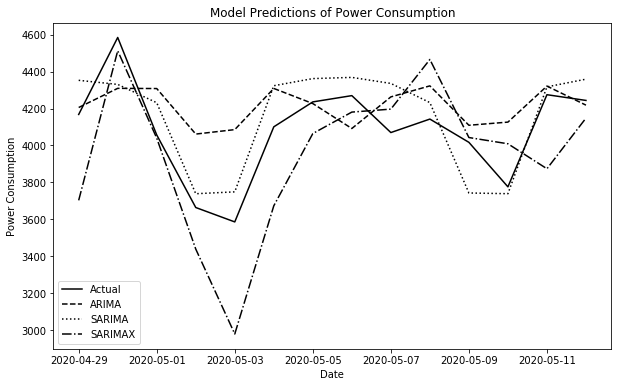

In [22]:
# Plot predictions
plt.figure(figsize=(10,6))
plt.plot(results.ACTUAL, label = "Actual",  color = 'black', linestyle='solid')
plt.plot(results.ARIMA, label = "ARIMA",  color = 'black', linestyle='dashed')
plt.plot(results.SARIMA, label = "SARIMA",  color = 'black', linestyle='dotted')
plt.plot(results.SARIMAX, label = "SARIMAX",  color = 'black', linestyle='dashdot')
plt.title('Model Predictions of Power Consumption')
plt.ylabel('Power Consumption')
plt.xlabel('Date')
plt.grid(False)
plt.legend()

plt.savefig("Preds.png")

plt.show()

In [ ]:
# Plot SARIMA predictions
plt.figure(figsize=(10,6))
plt.plot(results.ACTUAL, label = "Actual",  color = 'black', linestyle='solid')
plt.plot(results.ARIMA, label = "Prediction",  color = 'black', linestyle='dashed')
plt.title('ARIMA Predictions')
plt.ylabel('Power Consumption')
plt.xlabel('Date')
plt.grid(False)
plt.legend()

plt.show()

In [ ]:
# Plot SARIMA predictions
plt.figure(figsize=(10,6))
plt.plot(results.ACTUAL, label = "Actual",  color = 'black', linestyle='solid')
plt.plot(results.SARIMA, label = "Prediction",  color = 'black', linestyle='dashed')
plt.title('SARIMA Predictions')
plt.ylabel('Power Consumption')
plt.xlabel('Date')
plt.grid(False)
plt.legend()

plt.show()

In [ ]:
# Plot SARIMAX predictions
plt.figure(figsize=(10,6))
plt.plot(results.ACTUAL, label = "Actual",  color = 'black', linestyle='solid')
plt.plot(results.SARIMAX, label = "Prediction",  color = 'black', linestyle='dashed')
plt.title('SARIMAX Predictions')
plt.ylabel('Power Consumption')
plt.xlabel('Date')
plt.grid(False)
plt.legend()

plt.show()

In [ ]:
# Plot predictions
plt.figure(figsize=(10,6))
plt.plot(results.ARIMA_LOGERROR, label = "ARIMA",  color = 'black', linestyle='dashed')
plt.plot(results.SARIMA_LOGERROR, label = "SARIMA",  color = 'black', linestyle='dotted')
plt.plot(results.SARIMAX_LOGERROR, label = "SARIMAX",  color = 'black', linestyle='dashdot')
plt.title('Model Log Errors of Predictions')
plt.ylabel('Log Error')
plt.xlabel('Date')
plt.grid(False)
plt.legend()

plt.show()

In [ ]:
# results[['ARIMA_SQRERROR','SARIMA_SQRERROR','SARIMAX_SQRERROR']].plot()

In [ ]:
# results[['ARIMA_ERROR','SARIMA_ERROR','SARIMAX_ERROR']].plot()

In [ ]:
SARIMA_Largest = results.nlargest(10,['SARIMA_SQRERROR']).index
SARIMAX_Largest = results.nlargest(10,['ARIMA_SQRERROR']).index
ARIMA_Largest = results.nlargest(10,['SARIMAX_SQRERROR']).index

In [ ]:
# results.nlargest(10,['SARIMA_SQRERROR'])

In [ ]:
# results.nlargest(10,['SARIMAX_SQRERROR'])

In [ ]:
# results.nlargest(10,['ARIMA_SQRERROR'])

In [23]:
final_pred = SARIMA.predict(preds_start,preds_end)
print('SARIMA (2,1,1)(1,1,1,7)\n------------------------')
print('RMSE:{}'.format(mean_squared_error(preds,final_pred, squared=False)))
print('r2:{}'.format(r2_score(preds,final_pred)))
print('MAE:{}'.format(mean_absolute_error(preds,final_pred)))

SARIMA (2,1,1)(1,1,1,7)
------------------------
RMSE:308.5506625743083
r2:0.058112332260146116
MAE:270.4275431765505


In [24]:
final_results = pd.DataFrame({'ACTUAL':preds,'SARIMA':final_pred})
final_results

,ACTUAL,SARIMA
2020-05-13,4191.0,4365.230770
2020-05-14,4050.0,4332.059421
2020-05-15,3954.0,4227.969847
2020-05-16,3617.0,3738.690708
2020-05-17,3541.0,3734.077845
2020-05-18,3964.0,4312.846999
2020-05-19,4044.0,4354.720692
2020-05-20,4009.0,4360.808330
2020-05-21,4008.0,4327.608843
2020-05-22,4173.0,4223.507295


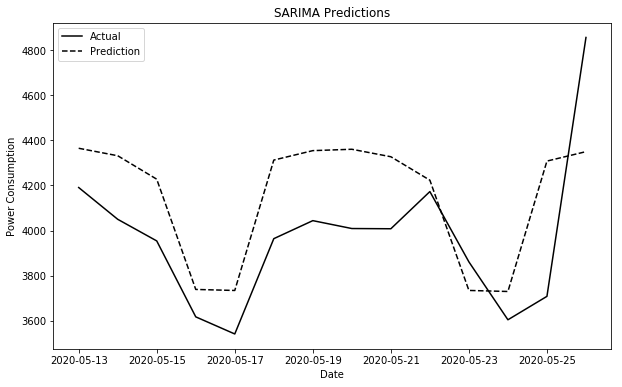

In [26]:
# Plot SARIMA predictions
plt.figure(figsize=(10,6))
plt.plot(final_results.ACTUAL, label = "Actual",  color = 'black', linestyle='solid')
plt.plot(final_results.SARIMA, label = "Prediction",  color = 'black', linestyle='dashed')
plt.title('SARIMA Predictions')
plt.ylabel('Power Consumption')
plt.xlabel('Date')
plt.grid(False)
plt.legend()

plt.savefig("forecast.png")

plt.show()